# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-09-25 19:15:01 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [ ]:
Pkg.add("NPZ")


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
n1=400

# exponentially decaying sinusiods with different frequencies
inp = zeros(Float32,n1)
for j in n1÷15:n1÷5:n1
    wave = zeros(Float32,n1)
    for x in j:399
        y = (x-j)/400
        wave[x] = exp(-y*15)*sin(y*0.95*j)
    end
    inp += wave
end

res = similar(inp);
bak = similar(inp);

In [ ]:
import Pkg; Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
using Plots

function stems(data, label, color)
    "plot data using stems"
    plt=plot(zeros(Float32, n1), label=:none, color=:black)
    plot!(plt, data, line=:stem,
          label=label, color=color, legend=:outerleft,
          xlim=[0.5, n1+0.5], border=:none)
    return plt
end

stems (generic function with 1 method)

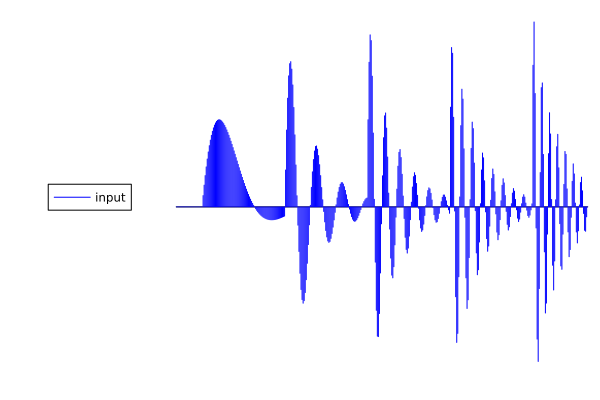

In [ ]:
plot_input = stems(inp,"input",:blue)

In [ ]:
function stream!(inv::Bool, d::Vector{T}, r::Vector{T}, na::Int, λ::Real) where T <: Real
    a = zeros(T, na) # streaming PEF
    dd = da = zero(T) # d (dot) d, d (dot) a
    for ia in 1:na
        if (inv)
            d[ia] = r[ia]
        else
            r[ia] = d[ia]
        end
        dd += d[ia]*d[ia]
    end
    for i1 in na+1:n1
        if (inv) # from r to d
            rn = r[i1] / λ
            dn = rn * (λ + dd) - da
            d[i1] = dn
        else     # from d to r
            dn = d[i1]
            rn = (dn + da) / (λ + dd)
            r[i1] = λ * rn
        end
        # update PEF
        for ia in 1:na; a[ia] -= rn * d[i1-ia]; end
        # update dd and da
        dd += dn*dn - d[i1-na] * d[i1-na]
        da = dn * a[1]
        for ia in 2:na; da += a[ia] * d[i1-ia+1]; end
    end
end

stream! (generic function with 1 method)

In [ ]:
stream!(false, inp, res, 2, 0.1)
plot_decon = stems(res, "decon", :green);

In [ ]:
stream!(true, bak, res, 2, 0.1)
plot_inverse = stems(bak,"inverse",:purple);

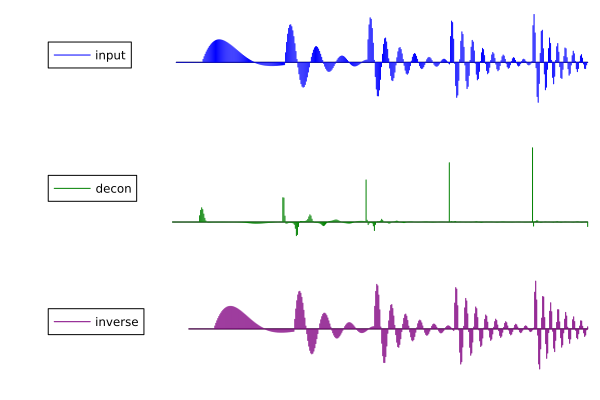

In [ ]:
plot(plot_input, plot_decon, plot_inverse, layout=(3, 1))

In [ ]:
savefig("stream.pdf")

"/content/stream.pdf"

### Multiple dimensions

In [ ]:
inp2 = deepcopy(inp)
known = ones(Bool,n1)

# Cut holes in the data and create a mask
for hole in (55, 153, 246, 301, 376)
    inp2[hole:hole+20] .= 0
    known[hole:hole+20] .= false
end

In [ ]:
function stream_missing!(d::Vector{T}, k::Vector{Bool}, na::Int, λ::Real) where T <: Real
    a = zeros(T, na) # streaming PEF
    da = zero(T) # d (dot) a
    dd = zero(T) # d (dot) d
    for ia in 1:na
        dd += d[ia]*d[ia]
    end
    for i1 in na+1:n1
        if (k[i1]) # from d to r
            dn = d[i1]
            rn = (dn + da) / (λ + dd)
        else       # assume r=0
            dn = - da
            rn = zero(T)
            d[i1] = dn
        end
        # update PEF
        for ia in 1:na
            a[ia] -= rn * d[i1-ia]
        end
        # update dd and da
        dd += dn*dn - d[i1-na] * d[i1-na]
        da = dn * a[1]
        for ia in 2:na
            da += a[ia] * d[i1-ia+1]
        end
    end
end

stream_missing! (generic function with 1 method)

In [ ]:
plot_ideal = stems(inp,"ideal ",:blue);
plot_hole = stems(inp2,"input ",:green);

In [ ]:
miss = deepcopy(inp2)
stream_missing!(miss,known,2,0.05)

In [ ]:
plot_interp = stems(miss,"filled",:purple);

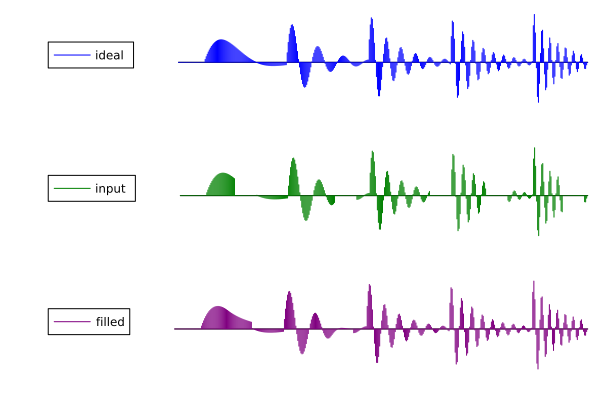

In [ ]:
plot(plot_ideal, plot_hole, plot_interp, layout=(3, 1))

In [ ]:
savefig("mstream.pdf")

"/content/mstream.pdf"

In [ ]:
import Pkg; Pkg.add("ZipFile")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
using ZipFile

# download data from a public server
download("https://zenodo.org/api/records/11099632/files-archive", "files.zip")
# unzip the archive file
r = ZipFile.Reader("files.zip")

ZipFile.Reader for IOStream(<file files.zip>) containing 3 files:

uncompressedsize method  mtime            name
----------------------------------------------
          125000 Store   2024-09-25 21-34 seis.rsf@
           65536 Store   2024-09-25 21-34 wood.rsf@
           65536 Store   2024-09-25 21-34 herr.rsf@


In [ ]:
# make a dictionary of files for easy access
patterns = Dict{String, IO}()
for file in r.files
    name = splitext(file.name)[1]
    patterns[name] = file
end

In [ ]:
# download "wood" pattern
wood = Array{Float32}(undef, 128, 128) # single-precision array
read!(patterns["wood"], wood)

128×128 Matrix{Float32}:
 -122.865   -133.865     -116.865    -33.8653  …     3.1347   -69.8653    -8.8653    49.1347
   32.1347   -97.8653    -123.865   -138.865        18.1347    34.1347    14.1347     0.134705
    6.1347    52.1347     -62.8653  -118.865       -97.8653   -63.8653    64.1347    28.1347
  -18.8653    -5.8653      63.1347    20.1347     -125.865   -117.865    -94.8653    -0.865295
    2.1347   -20.8653     -10.8653    29.1347     -143.865   -127.865   -109.865   -107.865
   69.1347    -0.865295   -38.8653     2.1347  …  -145.865   -140.865   -122.865   -113.865
  100.135     63.1347      48.1347    -8.8653     -145.865   -145.865   -139.865   -137.865
   85.1347    99.1347      89.1347    60.1347     -133.865   -145.865   -146.865   -145.865
   82.1347    69.1347      84.1347    86.1347      -89.8653  -113.865   -143.865   -145.865
   75.1347    69.1347      76.1347    81.1347      -39.8653   -72.8653   -95.8653  -134.865
   69.1347    67.1347      89.1347    75.1347  

In [ ]:
wood_julia = npzwrite("wood_julia.npy", wood)


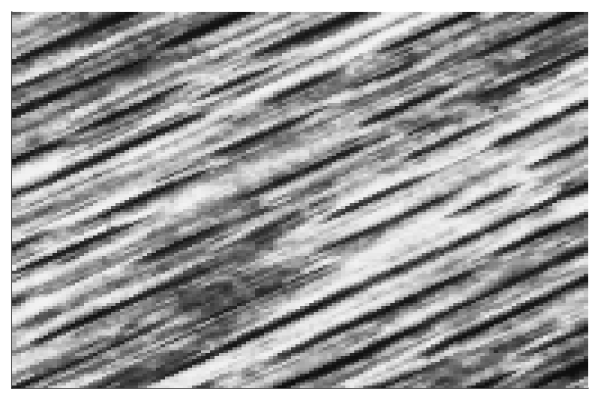

In [ ]:
heatmap(wood,axis=nothing,legend=:none,color=:grays)

In [ ]:
function punch_hole(data::Matrix{T}) where T <: Real
    # make an elliptical hole
    n1, n2 = size(data)
    hole = similar(data)
    mask = zeros(Bool, n1, n2)
    for i2 in 1:n2, i1 in 1:n1
        x = (i1-1)/n1 - 0.5
        y = (i2-1)/n2 - 0.3
        u =  x + y
        v = (x - y)/2
        if (u*u + v*v < 0.15)
            hole[i1,i2] = zero(T)
        else
            hole[i1,i2] = data[i1,i2]
            mask[i1,i2] = true
        end
    end
    return hole, mask
end

whole, wmask = punch_hole(wood);

In [ ]:
whole_julia = npzwrite("whole_julia.npy", whole)
wmask_julia = npzwrite("wmask_julia.npy", wmask)

In [ ]:
holepad = hcat(zeros(Float32, size(whole, 1), 20), whole)

128×148 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …     3.1347   -69.8653    -8.8653    49.1347
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       18.1347    34.1347    14.1347     0.134705
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      -97.8653   -63.8653    64.1347    28.1347
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     -125.865   -117.865    -94.8653    -0.865295
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     -143.865   -127.865   -109.865   -107.865
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  -145.865   -140.865   -122.865   -113.865
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     -145.865   -145.865   -139.865   -137.865
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     -133.865   -145.865   -146.865   -145.865
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      -89.8653  -113.865   -143.865   -145.865
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      -39.8653   -72.8653   -95.8653  -134.865
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …   -75.865

In [ ]:
holepad[:,20]

128-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [ ]:
ci = CartesianIndices(holepad)

CartesianIndices((128, 148))

In [ ]:
last(ci)

CartesianIndex(128, 148)

In [ ]:
Tuple(last(ci))


(128, 148)

In [ ]:
mid = CartesianIndex(Tuple(last(ci)) .÷ 2)

CartesianIndex(64, 74)

In [ ]:
hmid = LinearIndices(ci)[mid]

9408

In [ ]:
LinearIndices(ci)

128×148 LinearIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}:
   1  129  257  385  513  641  769   897  1025  1153  …  18177  18305  18433  18561  18689  18817
   2  130  258  386  514  642  770   898  1026  1154     18178  18306  18434  18562  18690  18818
   3  131  259  387  515  643  771   899  1027  1155     18179  18307  18435  18563  18691  18819
   4  132  260  388  516  644  772   900  1028  1156     18180  18308  18436  18564  18692  18820
   5  133  261  389  517  645  773   901  1029  1157     18181  18309  18437  18565  18693  18821
   6  134  262  390  518  646  774   902  1030  1158  …  18182  18310  18438  18566  18694  18822
   7  135  263  391  519  647  775   903  1031  1159     18183  18311  18439  18567  18695  18823
   8  136  264  392  520  648  776   904  1032  1160     18184  18312  18440  18568  18696  18824
   9  137  265  393  521  649  777   905  1033  1161     18185  18313  18441  18569  18697  18825
  10  138  266  394  522  650  778   906  1034 

In [ ]:
holepad[30,70]

0.0f0

In [ ]:
function helix(lag::Vector{Tuple{T, T}}, ci::CartesianIndices) where T <: Integer
    "convert filter lags to helix lags for a given grid"
    println("lag : $lag")
    println("ci : $ci")
    # middle of the grid
    mid = CartesianIndex(Tuple(last(ci)) .÷ 2)
    println("mid : $mid" )
    # helix index of middle
    hmid = LinearIndices(ci)[mid]
    println("hmid : $hmid")
    #println("map(x -> CartesianIndex(x) + mid, lag)",map(x -> CartesianIndex(x) + mid, lag))
    println("LinearIndices(ci)[map(x -> CartesianIndex(x) + mid, lag)] : ", LinearIndices(ci)[map(x -> CartesianIndex(x) + mid, lag)])
    # from Cartesian shift to helix shift
    return LinearIndices(ci)[map(x -> CartesianIndex(x) + mid, lag)] .- hmid
end

helix (generic function with 1 method)

In [ ]:
hlx = helix(lag,ci)



lag : [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)]
ci : CartesianIndices((128, 148))
mid : CartesianIndex(64, 74)
hmid : 9408
LinearIndices(ci)[map(x -> CartesianIndex(x) + mid, lag)] : [9409, 9410, 9411, 9412, 9413]


5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [ ]:
zeros(Float32, size(whole, 1), 20)

128×20 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [ ]:
import Random

function stream_missing_helix!(d, k,
                               lag::Vector{Tuple{I, I}},
                               λ::Real, std=0, seed=1) where I <: Integer
    "Fill missing data in multiple dimensions using streaming PEF on a helix"
    n1, na = length(d), length(lag)
    hlag = helix(lag, CartesianIndices(d))
    maxlag = maximum(hlag)
    T = eltype(d)
    a = zeros(T, na) # streaming PEF
    da = zero(T) # d (dot) a
    dd = zero(T) # d (dot) d

    for ia in 1:na
        dd += d[maxlag+1-hlag[ia]]^2
    end
    Random.seed!(seed)
    for i1 in maxlag+1:n1
        if (k[i1])
            dn = d[i1]
            rn = (dn + da) / (λ + dd)
        else # assume r_n is random
            rn = std * randn() / λ
            dn = rn * (λ + dd) - da
            d[i1] = dn
        end
        # update PEF
        for ia in 1:na
            a[ia] -= rn * d[i1-hlag[ia]]
        end
        # update dd and da
        dd += dn * dn - d[i1-maxlag] * d[i1-maxlag]
        da = dn * a[1]
        for ia in 2:na
            da += a[ia] * d[i1+1-hlag[ia]]
        end
    end
end

stream_missing_helix! (generic function with 3 methods)

In [ ]:
# 11 x 11 PEF
lag=[(x,0) for x in 1:5]
print(lag)
for k in 1:10
    lag = vcat(lag,[(x,k) for x in -5:5])
end

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)]

In [ ]:
lag

115-element Vector{Tuple{Int64, Int64}}:
 (1, 0)
 (2, 0)
 (3, 0)
 (4, 0)
 (5, 0)
 (-5, 1)
 (-4, 1)
 (-3, 1)
 (-2, 1)
 (-1, 1)
 (0, 1)
 (1, 1)
 (2, 1)
 ⋮
 (5, 9)
 (-5, 10)
 (-4, 10)
 (-3, 10)
 (-2, 10)
 (-1, 10)
 (0, 10)
 (1, 10)
 (2, 10)
 (3, 10)
 (4, 10)
 (5, 10)

In [ ]:
#lag_arr = map(x -> x, lag)
#lag_arr

lag_julia = npzwrite("lag_julia.npy", lag)



LoadError: unsupported type Tuple{Int64, Int64}

In [ ]:
function fill_hole(forward::Bool, hole, mask, pad::Integer, noise=0, seed=1)
    if forward
        holepad = hcat(zeros(Float32, size(hole, 1), pad), hole)
        npzwrite("holepad_julia.npy", holepad)
        maskpad = hcat(zeros(Bool, size(hole, 1), pad), mask)
        npzwrite("maskpad_julia.npy", maskpad)
        stream_missing_helix!(holepad, maskpad, lag, 1e6, noise, seed)
        return holepad[:,pad+1:end]
    else
        rhole = reverse(hole)
        rmask = reverse(mask)
        holepad = hcat(zeros(Float32, size(rhole, 1), pad), rhole)
        maskpad = hcat(zeros(Bool, size(rhole, 1), pad), rmask)
        stream_missing_helix!(holepad, maskpad, lag, 1e6, noise, seed+1)
        return reverse(holepad[:,pad+1:end])
    end
end

fill_hole (generic function with 3 methods)

In [ ]:
filled1 = fill_hole(true, whole, wmask, 20);
filled2 = fill_hole(false, whole, wmask, 20);

lag : [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (-5, 1), (-4, 1), (-3, 1), (-2, 1), (-1, 1), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (-5, 2), (-4, 2), (-3, 2), (-2, 2), (-1, 2), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (-5, 3), (-4, 3), (-3, 3), (-2, 3), (-1, 3), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (-5, 4), (-4, 4), (-3, 4), (-2, 4), (-1, 4), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (-5, 5), (-4, 5), (-3, 5), (-2, 5), (-1, 5), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (-5, 6), (-4, 6), (-3, 6), (-2, 6), (-1, 6), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (-5, 7), (-4, 7), (-3, 7), (-2, 7), (-1, 7), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (-5, 8), (-4, 8), (-3, 8), (-2, 8), (-1, 8), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (-5, 9), (-4, 9), (-3, 9), (-2, 9), (-1, 9), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (-5, 10), (-4, 10), (-3, 10), (-2, 10), (-1, 10), (0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10)]
ci : Cartesi

In [ ]:
filled1_julia = npzwrite("c_filled1_julia.npy", filled1)
filled2_julia = npzwrite("c_filled2_julia.npy", filled2)

In [ ]:
plot2(data, title) = heatmap(data, axis=nothing, yflip=:true, clim=(-137, 137),
                             legend=:none, color=:grays, title=title)

plot2 (generic function with 1 method)

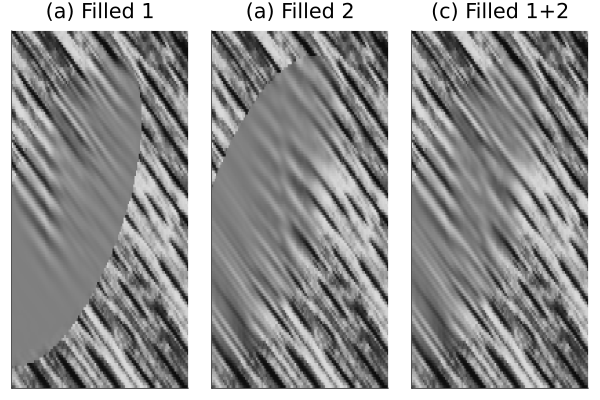

In [ ]:
p1 = plot2(filled1, "(a) Filled 1")
p2 = plot2(filled2, "(a) Filled 2")
p3 = plot2(filled1 + filled2 - whole, "(c) Filled 1+2")
plot(p1, p2, p3, layout=(1, 3))

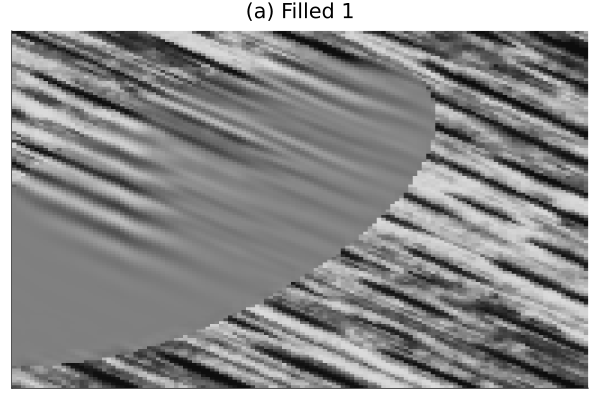

In [ ]:
p1 = plot2(filled1, "(a) Filled 1")

In [ ]:
filled1

128×128 Matrix{Float32}:
 -122.865        -133.865     -116.865    …     3.1347   -69.8653    -8.8653    49.1347
   32.1347        -97.8653    -123.865         18.1347    34.1347    14.1347     0.134705
    6.1347         52.1347     -62.8653       -97.8653   -63.8653    64.1347    28.1347
  -18.8653         -5.8653      63.1347      -125.865   -117.865    -94.8653    -0.865295
    2.1347        -20.8653     -10.8653      -143.865   -127.865   -109.865   -107.865
   69.1347         -0.865295   -38.8653   …  -145.865   -140.865   -122.865   -113.865
  100.135          63.1347      48.1347      -145.865   -145.865   -139.865   -137.865
   85.1347         99.1347      89.1347      -133.865   -145.865   -146.865   -145.865
   82.1347         69.1347      84.1347       -89.8653  -113.865   -143.865   -145.865
   75.1347         69.1347      76.1347       -39.8653   -72.8653   -95.8653  -134.865
   69.1347         67.1347      89.1347   …   -75.8653   -28.8653   -29.8653   -92.8653
    8.134

In [ ]:
savefig("interp.pdf")

"/content/interp.pdf"

lag : [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (-5, 1), (-4, 1), (-3, 1), (-2, 1), (-1, 1), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (-5, 2), (-4, 2), (-3, 2), (-2, 2), (-1, 2), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (-5, 3), (-4, 3), (-3, 3), (-2, 3), (-1, 3), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (-5, 4), (-4, 4), (-3, 4), (-2, 4), (-1, 4), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (-5, 5), (-4, 5), (-3, 5), (-2, 5), (-1, 5), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (-5, 6), (-4, 6), (-3, 6), (-2, 6), (-1, 6), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (-5, 7), (-4, 7), (-3, 7), (-2, 7), (-1, 7), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (-5, 8), (-4, 8), (-3, 8), (-2, 8), (-1, 8), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (-5, 9), (-4, 9), (-3, 9), (-2, 9), (-1, 9), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (-5, 10), (-4, 10), (-3, 10), (-2, 10), (-1, 10), (0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10)]
ci : Cartesi

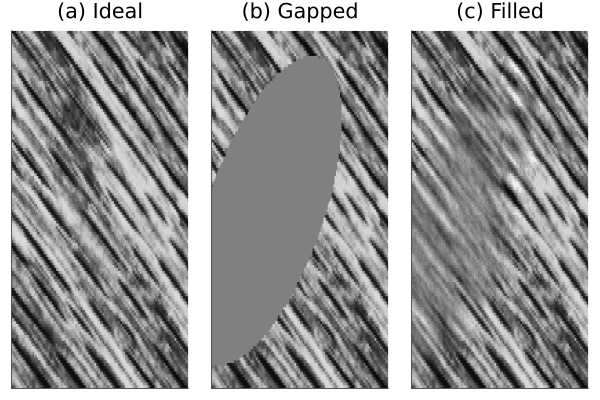

In [ ]:
filled = fill_hole(true,  whole, wmask, 20, 2) +
         fill_hole(false, whole, wmask, 20, 2) - whole

p1 = plot2(wood, "(a) Ideal")
p2 = plot2(whole, "(b) Gapped")
p3 = plot2(filled, "(c) Filled")
plot(p1, p2, p3, layout=(1, 3))

In [ ]:
savefig("wood-hole.pdf")

"/content/wood-hole.pdf"

lag : [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (-5, 1), (-4, 1), (-3, 1), (-2, 1), (-1, 1), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (-5, 2), (-4, 2), (-3, 2), (-2, 2), (-1, 2), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (-5, 3), (-4, 3), (-3, 3), (-2, 3), (-1, 3), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (-5, 4), (-4, 4), (-3, 4), (-2, 4), (-1, 4), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (-5, 5), (-4, 5), (-3, 5), (-2, 5), (-1, 5), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (-5, 6), (-4, 6), (-3, 6), (-2, 6), (-1, 6), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (-5, 7), (-4, 7), (-3, 7), (-2, 7), (-1, 7), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (-5, 8), (-4, 8), (-3, 8), (-2, 8), (-1, 8), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (-5, 9), (-4, 9), (-3, 9), (-2, 9), (-1, 9), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (-5, 10), (-4, 10), (-3, 10), (-2, 10), (-1, 10), (0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10)]
ci : Cartesi

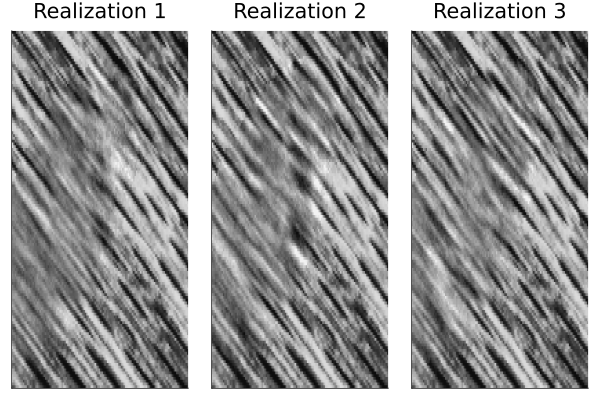

In [ ]:
p = Array{Plots.Plot}(undef,3)
for k in 1:3
    filled = fill_hole(true,  whole, wmask, 20, 2, k) +
             fill_hole(false, whole, wmask, 20, 2, k+3) - whole
    p[k] = plot2(filled, "Realization $k")
end
plot(p[1], p[2], p[3], layout=(1, 3))

In [ ]:
savefig("realiz.pdf")

"/content/realiz.pdf"

In [ ]:
# "herring" pattern
herr = Array{Float32}(undef, 128, 128) # single-precision array
# read data
read!(patterns["herr"], herr)
# make a hole
hhole, hmask = punch_hole(herr);

lag : [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (-5, 1), (-4, 1), (-3, 1), (-2, 1), (-1, 1), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (-5, 2), (-4, 2), (-3, 2), (-2, 2), (-1, 2), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (-5, 3), (-4, 3), (-3, 3), (-2, 3), (-1, 3), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (-5, 4), (-4, 4), (-3, 4), (-2, 4), (-1, 4), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (-5, 5), (-4, 5), (-3, 5), (-2, 5), (-1, 5), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (-5, 6), (-4, 6), (-3, 6), (-2, 6), (-1, 6), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (-5, 7), (-4, 7), (-3, 7), (-2, 7), (-1, 7), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (-5, 8), (-4, 8), (-3, 8), (-2, 8), (-1, 8), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (-5, 9), (-4, 9), (-3, 9), (-2, 9), (-1, 9), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (-5, 10), (-4, 10), (-3, 10), (-2, 10), (-1, 10), (0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10)]
ci : Cartesi

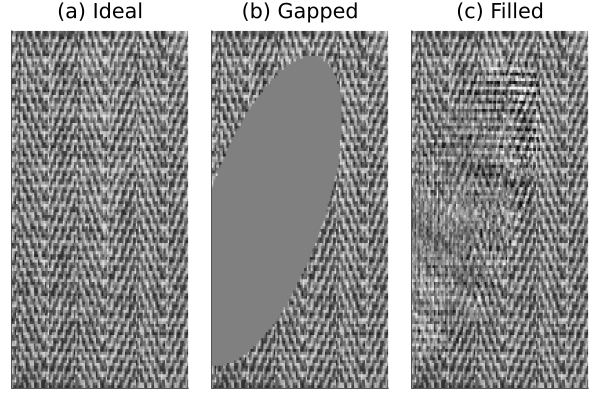

In [ ]:
filled = fill_hole(true,  hhole, hmask, 20, 6) +
         fill_hole(false, hhole, hmask, 20, 6) - hhole

p1 = plot2(herr, "(a) Ideal")
p2 = plot2(hhole, "(b) Gapped")
p3 = plot2(filled, "(c) Filled")
plot(p1, p2, p3, layout=(1, 3))

In [ ]:
savefig("herr-hole.pdf")

"/content/herr-hole.pdf"

In [ ]:
# "seismic" pattern
seis = Array{Float32}(undef, 250, 125) # single-precision array
# read data
read!(patterns["seis"], seis)

250×125 Matrix{Float32}:
      0.0      0.0      0.0      0.0      0.0  …      0.0      0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0      0.0  …      0.0      0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.

In [ ]:
using Statistics

# normalize
m = mean(seis)
seis .-= m
scale = std(wood)/std(seis)
seis *= scale

# make a hole
shole, smask = punch_hole(seis);

lag : [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (-5, 1), (-4, 1), (-3, 1), (-2, 1), (-1, 1), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (-5, 2), (-4, 2), (-3, 2), (-2, 2), (-1, 2), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (-5, 3), (-4, 3), (-3, 3), (-2, 3), (-1, 3), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (-5, 4), (-4, 4), (-3, 4), (-2, 4), (-1, 4), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (-5, 5), (-4, 5), (-3, 5), (-2, 5), (-1, 5), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (-5, 6), (-4, 6), (-3, 6), (-2, 6), (-1, 6), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (-5, 7), (-4, 7), (-3, 7), (-2, 7), (-1, 7), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (-5, 8), (-4, 8), (-3, 8), (-2, 8), (-1, 8), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (-5, 9), (-4, 9), (-3, 9), (-2, 9), (-1, 9), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (-5, 10), (-4, 10), (-3, 10), (-2, 10), (-1, 10), (0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10)]
ci : Cartesi

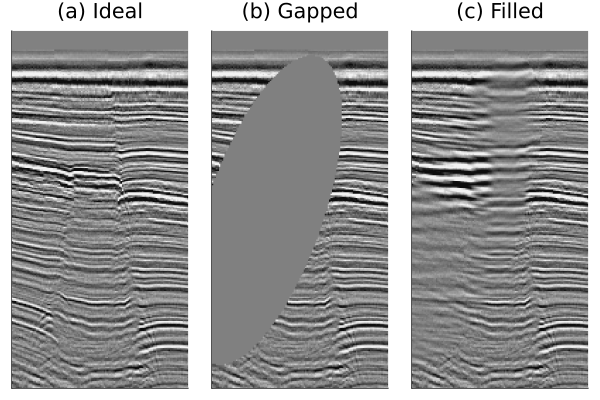

In [ ]:
filled = fill_hole(true,  shole, smask, 20, 0.7) +
         fill_hole(false, shole, smask, 20, 0.7) - shole

p1 = plot2(seis, "(a) Ideal")
p2 = plot2(shole, "(b) Gapped")
p3 = plot2(filled, "(c) Filled")
plot(p1, p2, p3, layout=(1, 3))

In [ ]:
savefig("WGstack-hole.pdf")

"/content/WGstack-hole.pdf"

In [ ]:
function stream_helix!(inv::Bool, d, r, lag::Vector{Tuple{I, I}}, λ::Real) where I <: Integer
    n1, na = length(d), length(lag)
    hlag = helix(lag, CartesianIndices(d))
    maxlag = maximum(hlag)
    T = eltype(d)
    a = zeros(T, na) # streaming PEF
    for i1 in 1:maxlag
        if (inv)
            d[i1] = r[i1]
        else
            r[i1] = d[i1]
        end
    end
    da = zero(T) # d (dot) a
    dd = zero(T) # d (dot) d
    for ia in 1:na
        dd += d[maxlag+1-hlag[ia]]^2
    end
    for i1 in maxlag+1:n1
        if (inv)
            rn = r[i1] / λ
            dn = rn * (λ + dd) - da
            d[i1] = dn
        else
            dn = d[i1]
            rn = (dn + da) / (λ + dd)
            r[i1] = λ * rn
        end
        # update PEF
        for ia in 1:na
            a[ia] -= rn * d[i1-hlag[ia]]
        end
        # update dd and da
        dd += dn * dn - d[i1-maxlag] * d[i1-maxlag]
        da = dn * a[1]
        for ia in 2:na
            da += a[ia] * d[i1+1-hlag[ia]]
        end
    end
end

stream_helix! (generic function with 1 method)

In [ ]:
# apply helix filter
pad = hcat(zeros(Float32, size(seis, 1), 20), seis)
res= similar(pad)
stream_helix!(false, pad, res, lag, 1e6) # pad -> res
stream_helix!(true,  pad, res, lag, 1e6) # pad <- res

lag : [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (-5, 1), (-4, 1), (-3, 1), (-2, 1), (-1, 1), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (-5, 2), (-4, 2), (-3, 2), (-2, 2), (-1, 2), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (-5, 3), (-4, 3), (-3, 3), (-2, 3), (-1, 3), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (-5, 4), (-4, 4), (-3, 4), (-2, 4), (-1, 4), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (-5, 5), (-4, 5), (-3, 5), (-2, 5), (-1, 5), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (-5, 6), (-4, 6), (-3, 6), (-2, 6), (-1, 6), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (-5, 7), (-4, 7), (-3, 7), (-2, 7), (-1, 7), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (-5, 8), (-4, 8), (-3, 8), (-2, 8), (-1, 8), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (-5, 9), (-4, 9), (-3, 9), (-2, 9), (-1, 9), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (-5, 10), (-4, 10), (-3, 10), (-2, 10), (-1, 10), (0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10)]
ci : Cartesi

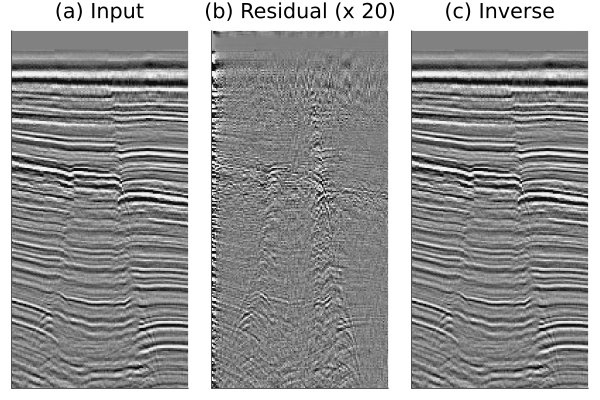

In [ ]:
p1 = plot2(seis, "(a) Input")
p2 = plot2(20*res[:,21:end], "(b) Residual (x 20)")
p3 = plot2(pad[:,21:end], "(c) Inverse")
plot(p1, p2, p3, layout=(1, 3))

# TMP ZONE

In [ ]:
function helix(lag::Vector{Tuple{T, T}}, ci::CartesianIndices) where T <: Integer
    "convert filter lags to helix lags for a given grid"
    # middle of the grid
    mid = CartesianIndex(Tuple(last(ci)) .÷ 2)
    println("mid  =  ", mid)
    # helix index of middle
    hmid = LinearIndices(ci)[mid]
    println("hmid =      ",hmid)
    #println("map(x -> CartesianIndex(x) + mid, lag)",map(x -> CartesianIndex(x) + mid, lag))
    println("LinearIndices(ci)[map(x -> CartesianIndex(x) + mid, lag)] : ", LinearIndices(ci)[map(x -> CartesianIndex(x) + mid, lag)])
    # from Cartesian shift to helix shift
    return LinearIndices(ci)[map(x -> CartesianIndex(x) + mid, lag)] .- hmid
end
lag=[(x,0) for x in 1:5]
println(lag)
println("map(x -> CartesianIndex(x) + mid, lag)    =    ",map(x -> CartesianIndex(x) + mid, lag))
println("map(x -> CartesianIndex(x), lag)    =    ",map(x -> CartesianIndex(x), lag))
hlx = helix(lag,ci)
println("hlx = ", hlx)


[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)]
map(x -> CartesianIndex(x) + mid, lag)    =    CartesianIndex{2}[CartesianIndex(65, 74), CartesianIndex(66, 74), CartesianIndex(67, 74), CartesianIndex(68, 74), CartesianIndex(69, 74)]
map(x -> CartesianIndex(x), lag)    =    CartesianIndex{2}[CartesianIndex(1, 0), CartesianIndex(2, 0), CartesianIndex(3, 0), CartesianIndex(4, 0), CartesianIndex(5, 0)]
mid  =  CartesianIndex(64, 74)
hmid =      9408
LinearIndices(ci)[map(x -> CartesianIndex(x) + mid, lag)] : [9409, 9410, 9411, 9412, 9413]
hlx = [1, 2, 3, 4, 5]


In [ ]:
using Pkg
Pkg.add("NPZ")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
using NPZ

# Load the .npy file
arr = npzread("filled1.npy")

#println(arr)  # Output: [1, 2, 3, 4, 5]
#filled1
#println(" $filled1[1]")
#println(arr[1] == filled1[1])
#println("$arr[prod(size(A))]")
#println("$filled1[prod(size(A))]")

LoadError: SystemError: opening file "filled1.npy": No such file or directory

In [ ]:
filled1

128×128 Matrix{Float32}:
 -122.865        -133.865     -116.865    …     3.1347   -69.8653    -8.8653    49.1347
   32.1347        -97.8653    -123.865         18.1347    34.1347    14.1347     0.134705
    6.1347         52.1347     -62.8653       -97.8653   -63.8653    64.1347    28.1347
  -18.8653         -5.8653      63.1347      -125.865   -117.865    -94.8653    -0.865295
    2.1347        -20.8653     -10.8653      -143.865   -127.865   -109.865   -107.865
   69.1347         -0.865295   -38.8653   …  -145.865   -140.865   -122.865   -113.865
  100.135          63.1347      48.1347      -145.865   -145.865   -139.865   -137.865
   85.1347         99.1347      89.1347      -133.865   -145.865   -146.865   -145.865
   82.1347         69.1347      84.1347       -89.8653  -113.865   -143.865   -145.865
   75.1347         69.1347      76.1347       -39.8653   -72.8653   -95.8653  -134.865
   69.1347         67.1347      89.1347   …   -75.8653   -28.8653   -29.8653   -92.8653
    8.134

In [ ]:
arr

LoadError: UndefVarError: arr not defined

In [ ]:
arr == filled1

LoadError: UndefVarError: arr not defined

In [ ]:
arr2 = npzread("filled2.npy")
arr2 == filled2

LoadError: SystemError: opening file "filled2.npy": No such file or directory

In [ ]:
parr2 = plot2(arr2, "imported from python arr2")

LoadError: UndefVarError: arr2 not defined

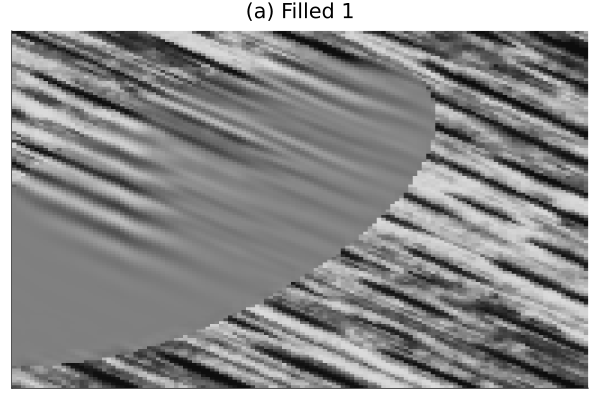

In [ ]:
p1 = plot2(filled1, "(a) Filled 1")

In [ ]:
npzwrite("julia_filled1.npy", filled1)